In [63]:

import time

import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms
from torchvision.datasets import CIFAR10

In [64]:
# Mini-Batch Gradient Descent
batch_size = 128

learning_rate = 0.1
num_epochs = 30
num_classes = 10

# the percentage of the training dataset to use as validation dataset
valid_percentage = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("now using device: ", device)

classes = (
    "Airplane",
    "Car",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
)

now using device:  cuda


## 网络结构

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*JEGNYy9rXMj_XN7W1Qjo9g.png)
![](https://img-blog.csdnimg.cn/20200104153325358.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rfc29ydA==,size_16,color_FFFFFF,t_70)

![](https://img-blog.csdnimg.cn/20200104162456690.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rfc29ydA==,size_16,color_FFFFFF,t_70)


```
    Input
      |
   Conv Layer
      |
   ReLU
      |
   Conv Layer
      |
      |----------------
      |               |
     ReLU             |
      |               |
     Output          Input
      |               |
      ----------------
           |
         Output
```


In [65]:
def conv3x3(in_channels, out_channels, stride=1):
    # 二维卷积层
    # in_channels：输入特征图的通道数。例如，对于RGB图像，in_channels为3。
    # out_channels：输出特征图的通道数。这个值决定了卷积核的数量，即我们希望提取多少个特征。
    # kernel_size：卷积核的大小，可以是一个整数或一个元组。例如，kernel_size=3表示使用3x3的卷积核。
    # stride：卷积核的步幅，决定卷积核在输入特征图上移动的步长。默认值为1。
    # padding：填充方式，为了保持特征图的尺寸，可以在输入特征图的边缘填充0。padding=1表示在所有边缘填充1个像素。
    # bias：是否添加偏置项。默认值为True。这里不使用偏置项（bias=False），因为后面有批量归一化层。
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    """
    A basic residual block for ResNet.

    Attributes:
        conv1: First convolutional layer.
        bn1: Batch normalization for the first convolutional layer.
        conv2: Second convolutional layer.
        bn2: Batch normalization for the second convolutional layer.
        shortcut: Shortcut connection to match input and output dimensions.
    """

    expansion: int = (
        1  # 输出通道数相对于输入通道数的扩展倍数。对于基本块，扩展倍数为1。
    )

    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes the basic block.

        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: Stride for the convolution. Default is 1.
        """
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(in_channels, out_channels, stride)
        # 对卷积层的输出进行归一化处理。这有助于加速训练并稳定模型。
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        # 在残差块中，如果输入和输出的形状不一致（例如通道数不同或步幅不为1），我们需要通过一个卷积层来调整输入的形状，使其与输出形状一致。
        if stride != 1 or in_channels != out_channels:
            # 如果需要，则定义一个包含1x1卷积层和批量归一化层的顺序容器。
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# Example usage
# Define an input tensor with shape (batch_size, in_channels, height, width)
x = torch.randn(1, 64, 32, 32)
# Create a basic block instance
block = BasicBlock(64, 64)
# Forward pass
out = block(x)
print(out.shape)

torch.Size([1, 64, 32, 32])


```
    Input
      |
   1x1 Conv (Reduction)
      |
   BatchNorm
      |
    ReLU
      |
   3x3 Conv
      |
   BatchNorm
      |
    ReLU
      |
   1x1 Conv (Expansion)
      |
   BatchNorm
      |----------------
      |               |
     ReLU             |
      |               |
     Output          Input
      |               |
      ----------------
           |
         Output
```


In [66]:
class Bottleneck(nn.Module):
    """
    A bottleneck residual block for ResNet.

    Attributes:
        conv1: First convolutional layer (1x1).
        bn1: Batch normalization for the first convolutional layer.
        conv2: Second convolutional layer (3x3).
        bn2: Batch normalization for the second convolutional layer.
        conv3: Third convolutional layer (1x1).
        bn3: Batch normalization for the third convolutional layer.
        shortcut: Shortcut connection to match input and output dimensions.
    """

    expansion: int = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        """
        Initializes the bottleneck block.

        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: Stride for the convolution. Default is 1.
        """
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=1,
            stride=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [67]:
class ResNet(nn.Module):
    """
    A ResNet model.

    Attributes:
        in_channels: Number of input channels.
        conv1: Initial convolutional layer.
        bn1: Batch normalization for the initial convolutional layer.
        maxpool: Max pooling layer.
        layer1: First layer of residual blocks.
        layer2: Second layer of residual blocks.
        layer3: Third layer of residual blocks.
        layer4: Fourth layer of residual blocks.
        avgpool: Global average pooling layer.
        fc: Fully connected layer.
    """

    def __init__(
        self, block: type[BasicBlock], num_blocks: list[int], num_classes: int = 1000
    ) -> None:
        """
        Initializes the ResNet model.

        Args:
            block: A residual block.
            num_blocks: A list containing the number of blocks in each layer.
            num_classes: Number of output classes. Default is 1000.
        """
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(
        self, block: type[BasicBlock], out_channels: int, num_blocks: int, stride: int
    ) -> nn.Sequential:
        """
        Creates a layer of residual blocks.

        Args:
            block: A residual block.
            out_channels: Number of output channels.
            num_blocks: Number of blocks in the layer.
            stride: Stride for the first block.

        Returns:
            A sequential container of residual blocks.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [68]:
def ResNet18(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-18 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-18 model.
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

summary(ResNet18(num_classes=num_classes), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 8, 8]             128
│    │    └─Sequential: 3-5              [1, 64, 8, 8]             --
│    └─BasicBlock: 2-2                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-6                  [1, 64, 8, 8]             36,8

In [69]:
def ResNet34(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-34 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-34 model.
    """
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


summary(ResNet34(num_classes=num_classes), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 8, 8]             128
│    │    └─Sequential: 3-5              [1, 64, 8, 8]             --
│    └─BasicBlock: 2-2                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-6                  [1, 64, 8, 8]             36,8

In [70]:
def ResNet50(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-50 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-50 model.
    """
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


summary(ResNet50(num_classes=num_classes), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 256, 8, 8]            --
│    └─Bottleneck: 2-1                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-5                  [1, 256, 8, 8]            16,384
│    │    └─BatchNorm2d: 3-6             [1, 256, 8, 8]            512
│    │    └─Sequential: 3-7              [1, 256, 8, 8]            

In [71]:
def ResNet101(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-101 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-101 model.
    """
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


summary(ResNet101(num_classes=num_classes), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 256, 8, 8]            --
│    └─Bottleneck: 2-1                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-5                  [1, 256, 8, 8]            16,384
│    │    └─BatchNorm2d: 3-6             [1, 256, 8, 8]            512
│    │    └─Sequential: 3-7              [1, 256, 8, 8]            

In [72]:
def ResNet152(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-152 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-152 model.
    """
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)


summary(ResNet152(num_classes=num_classes), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 256, 8, 8]            --
│    └─Bottleneck: 2-1                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-5                  [1, 256, 8, 8]            16,384
│    │    └─BatchNorm2d: 3-6             [1, 256, 8, 8]            512
│    │    └─Sequential: 3-7              [1, 256, 8, 8]            

In [73]:
# 数据预处理
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 转为Tensor
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),  # 归一化
    ]
)


train_data = CIFAR10(root="../data", train=True, download=True, transform=transform)
test_data = CIFAR10(root="../data", train=False, transform=transform)

# make indices for spliting the training dataset into training and validation
len_train = len(train_data)
indices = list(range(len_train))
np.random.shuffle(indices)
split = int(np.floor(valid_percentage * len_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# we use mini-batch gradient descent to train the model
train_loader = DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2
)

valid_loader = DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2
)

test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


In [74]:
# Checking the dataset size
def check_dataset(loader, set_name):
    print(f"{set_name} Set:")
    images, labels = next(iter(loader))
    print("batch count", len(loader))
    print("image size per batch", images.size())
    print("label size per batch", labels.size())


check_dataset(train_loader, "Training")
check_dataset(valid_loader, "Valid")
check_dataset(test_loader, "Testing")

Training Set:
batch count 313
image size per batch torch.Size([128, 3, 32, 32])
label size per batch torch.Size([128])
Valid Set:
batch count 79
image size per batch torch.Size([128, 3, 32, 32])
label size per batch torch.Size([128])
Testing Set:
batch count 79
image size per batch torch.Size([128, 3, 32, 32])
label size per batch torch.Size([128])


In [75]:
def eval_model(model, data_loader):
    model.eval()
    class_total = [0.0 for _ in range(num_classes)]
    class_correct = [0.0 for _ in range(num_classes)]
    sum_loss, num_correct, num_examples = 0.0, 0.0, 0

    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)

            # compute the model output
            outputs = model(features)
            _, predicted_labels = torch.max(outputs, 1)

            # compute the loss
            loss = F.cross_entropy(outputs, targets, reduction="sum")
            sum_loss += loss.item()

            # compute the correct radix
            num_examples += targets.size(0)
            num_correct += (predicted_labels == targets).sum().item()

            # compute each class 's correct count
            for i in range(targets.size(0)):
                label = targets[i].item()
                class_correct[label] += (predicted_labels[i] == label).item()
                class_total[label] += 1

    accuracy = num_correct / num_examples * 100
    avg_loss = sum_loss / num_examples

    return {
        "accuracy": accuracy,
        "avg_loss": avg_loss,
        "class_correct": class_correct,
        "class_total": class_total,
    }

In [77]:
# train model
def train(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    num_epochs: int = 25,
    optimizer=None,
    loss_fn=None,
    scheduler=None,
) -> dict:
    log_dict = {
        "train_loss_per_batch": [],
        "train_acc_per_epoch": [],
        "valid_acc_per_epoch": [],
        "train_loss_per_epoch": [],
        "valid_loss_per_epoch": [],
        "valid_loss_min": np.Inf,
        "learning_rates": [],  
    }
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        log_dict["learning_rates"].append(current_lr)
        print(
            f"Epoch {epoch+1:03d}/{num_epochs:03d} | Current Learning Rate: {current_lr}"
        )

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader, 0):
            features = features.to(device)
            targets = targets.to(device)

            # step1: predict the output
            outputs = model(features)
            loss = loss_fn(outputs, targets)

            # step2: update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_dict["train_loss_per_batch"].append(loss.item())
            if not batch_idx % 50:
                print(
                    f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}"
                )

        # each epoch, evaluate the model
        model.eval()
        with torch.set_grad_enabled(False):
            train_eval_res = eval_model(model, train_loader)
            train_acc = train_eval_res["accuracy"]
            train_loss = train_eval_res["avg_loss"]
            print(
                f"#Epoch: {epoch+1:03d}/{num_epochs:03d} | Train. Acc.: {train_acc:.3f}% | Loss: {train_loss:.3f}"
            )
            log_dict["train_loss_per_epoch"].append(train_loss)
            log_dict["train_acc_per_epoch"].append(train_acc)

            # * each epoch, evaluate the model on the validation dataset which is not used for training
            valid_eval_res = eval_model(model, valid_loader)
            valid_acc = valid_eval_res["accuracy"]
            valid_loss = valid_eval_res["avg_loss"]
            log_dict["valid_loss_per_epoch"].append(valid_loss)
            log_dict["valid_acc_per_epoch"].append(valid_acc)
            print(
                f"#Epoch: {epoch+1:03d}/{num_epochs:03d} | Valid. Acc.: {valid_acc:.3f}% | Loss: {valid_loss:.3f}"
            )
            # * save the model if the validation loss is decreased
            if valid_loss <= log_dict["valid_loss_min"]:
                print(
                    f"#Validation loss decreased ({log_dict['valid_loss_min']:.6f} --> {valid_loss:.6f}). Saving model ..."
                )
                torch.save(model.state_dict(), "model_cifar.pt")
                log_dict["valid_loss_min"] = valid_loss

        if(scheduler is not None):
            scheduler.step()
        print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

    print(f"Total Training Time: {(time.time() - start_time)/ 60:.2f} min")
    return log_dict


model = ResNet34(num_classes=10).to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

log_dict = train(
    model,
    train_loader,
    valid_loader,
    num_epochs=num_epochs,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
)

Epoch 001/030 | Current Learning Rate: 0.1
Epoch: 001/030 | Batch 0000/0313 | Loss: 2.6918
Epoch: 001/030 | Batch 0050/0313 | Loss: 3.4267
Epoch: 001/030 | Batch 0100/0313 | Loss: 2.1859
Epoch: 001/030 | Batch 0150/0313 | Loss: 1.8069
Epoch: 001/030 | Batch 0200/0313 | Loss: 1.9107
Epoch: 001/030 | Batch 0250/0313 | Loss: 1.7557
Epoch: 001/030 | Batch 0300/0313 | Loss: 1.8879
#Epoch: 001/030 | Train. Acc.: 34.892% | Loss: 1.736
#Epoch: 001/030 | Valid. Acc.: 33.990% | Loss: 1.757
#Validation loss decreased (inf --> 1.757078). Saving model ...
Time elapsed: 0.25 min
Epoch 002/030 | Current Learning Rate: 0.1
Epoch: 002/030 | Batch 0000/0313 | Loss: 1.6000
Epoch: 002/030 | Batch 0050/0313 | Loss: 1.7262
Epoch: 002/030 | Batch 0100/0313 | Loss: 1.6067
Epoch: 002/030 | Batch 0150/0313 | Loss: 1.7433
Epoch: 002/030 | Batch 0200/0313 | Loss: 1.5538
Epoch: 002/030 | Batch 0250/0313 | Loss: 1.6079
Epoch: 002/030 | Batch 0300/0313 | Loss: 1.4649
#Epoch: 002/030 | Train. Acc.: 45.640% | Loss: 1.

In [ ]:
model.load_state_dict(torch.load("model_cifar.pt"))

<All keys matched successfully>

In [ ]:
print(log_dict)

{'train_loss_per_batch': [2.6734869480133057, 11.36559772491455, 26.193599700927734, 15.671954154968262, 16.95000648498535, 20.59625816345215, 14.266789436340332, 17.83955955505371, 5.614006042480469, 25.119104385375977, 16.474594116210938, 13.107585906982422, 5.331871509552002, 8.88254451751709, 48.38567352294922, 5.399961948394775, 21.44438934326172, 12.275371551513672, 6.9762444496154785, 24.52137565612793, 14.525144577026367, 3.7256088256835938, 4.806554317474365, 3.8386778831481934, 19.6807861328125, 12.38447093963623, 5.3749847412109375, 15.630817413330078, 11.090142250061035, 4.288092136383057, 6.1420578956604, 3.234611749649048, 12.77653980255127, 7.596991539001465, 13.306966781616211, 2.8875043392181396, 2.8586909770965576, 2.3310160636901855, 2.5223207473754883, 23.311084747314453, 21.591312408447266, 4.042474746704102, 15.608348846435547, 6.127512454986572, 12.302845001220703, 8.810724258422852, 2.63226318359375, 3.2996182441711426, 5.06314754486084, 2.3057501316070557, 7.46

/tmp/ipykernel_99185/3534138568.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


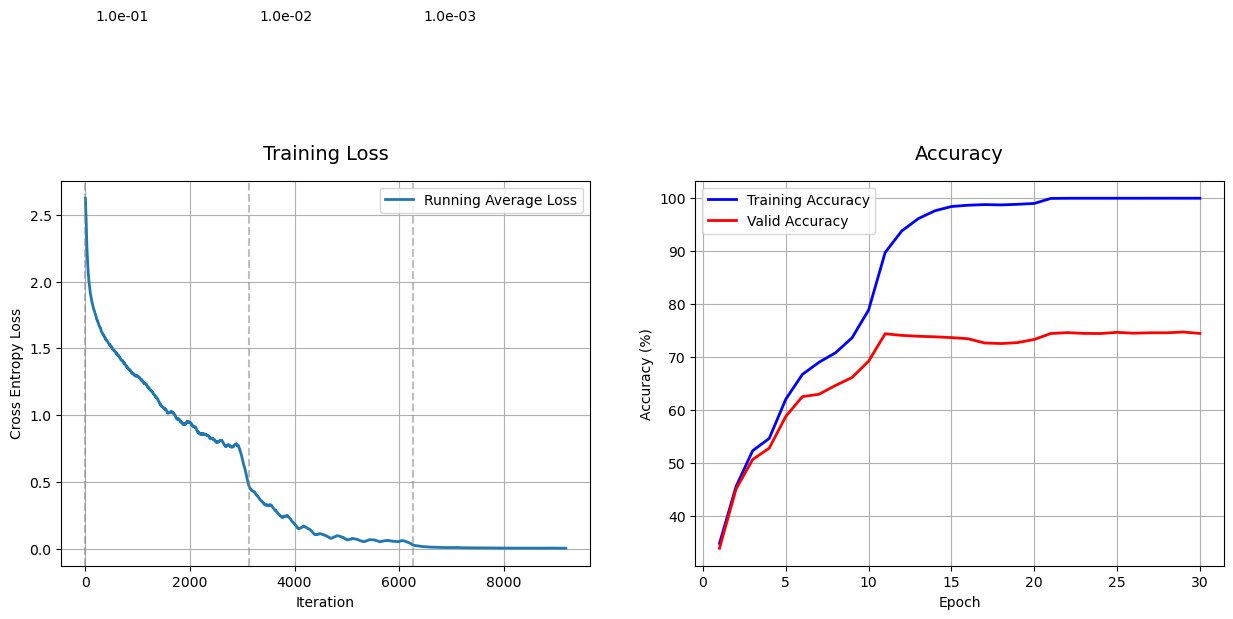

In [107]:
def plot_training_metrics(log_dict: dict):
    loss_list = log_dict["train_loss_per_batch"]
    train_acc = log_dict["train_acc_per_epoch"]
    valid_acc = log_dict["valid_acc_per_epoch"]
    learning_rates = log_dict["learning_rates"]
    train_loss_per_epoch = log_dict["train_loss_per_epoch"]
    running_avg_loss = np.convolve(loss_list, np.ones(200) / 200, mode="valid")

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # plot training loss
    # axs[0].plot(loss_list, label="Minibatch Loss")
    axs[0].plot(running_avg_loss, label="Running Average Loss", linewidth=2)
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Cross Entropy Loss")
    axs[0].set_title("Training Loss", fontsize=14, pad=15)
    axs[0].legend(loc="best")
    axs[0].grid(True)
    # axs[0].set_yscale("log")

    # 标记学习率变化
    iterations_per_epoch = len(loss_list) // num_epochs
    for epoch, lr in enumerate(learning_rates):
        if epoch == 0 or lr != learning_rates[epoch - 1]:
            axs[0].axvline(
                x=epoch * iterations_per_epoch, linestyle="--", color="gray", alpha=0.5
            )
            axs[0].text(
                epoch * iterations_per_epoch + 200,
                max(loss_list) / 2,
                f"{lr:.1e}",
                rotation=0,
                verticalalignment="bottom",
            )

    # plot training accuracy
    axs[1].plot(
        np.arange(1, len(train_acc) + 1),
        train_acc,
        label="Training Accuracy",
        color="blue",
        markersize=6,
        linewidth=2,
    )
    axs[1].plot(
        np.arange(1, len(valid_acc) + 1),
        valid_acc,
        label="Valid Accuracy",
        color="red",
        markersize=6,
        linewidth=2,
    )
    axs[1].xlim = (0, num_epochs + 1)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].set_title("Accuracy", fontsize=14, pad=15)
    axs[1].legend(loc="best")
    axs[1].grid(True)

    fig.savefig("training_performance.svg", format="svg")
    fig.show()


plot_training_metrics(log_dict)

In [ ]:
with torch.set_grad_enabled(False):
    test_eval_res = eval_model(model, test_loader)
    test_loss = test_eval_res["avg_loss"]
    test_acc = test_eval_res["accuracy"]
    class_correct = test_eval_res["class_correct"]
    class_total = test_eval_res["class_total"]

print(f"Test Loss: {test_loss:.4f}\n")
for i in range(num_classes):
    print(
        "Test Accuracy of %8s: %2d%% (%2d/%2d)"
        % (
            classes[i],
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i]),
        )
    )
print(f"\nTest Accuracy (Overall): {test_acc:.2f}%")

Test Loss: 0.8808

Test Accuracy of Airplane: 75% (753/1000)
Test Accuracy of      Car: 82% (823/1000)
Test Accuracy of     Bird: 59% (593/1000)
Test Accuracy of      Cat: 48% (483/1000)
Test Accuracy of     Deer: 71% (712/1000)
Test Accuracy of      Dog: 60% (606/1000)
Test Accuracy of     Frog: 80% (804/1000)
Test Accuracy of    Horse: 73% (736/1000)
Test Accuracy of     Ship: 79% (798/1000)
Test Accuracy of    Truck: 77% (778/1000)

Test Accuracy (Overall): 70.86%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

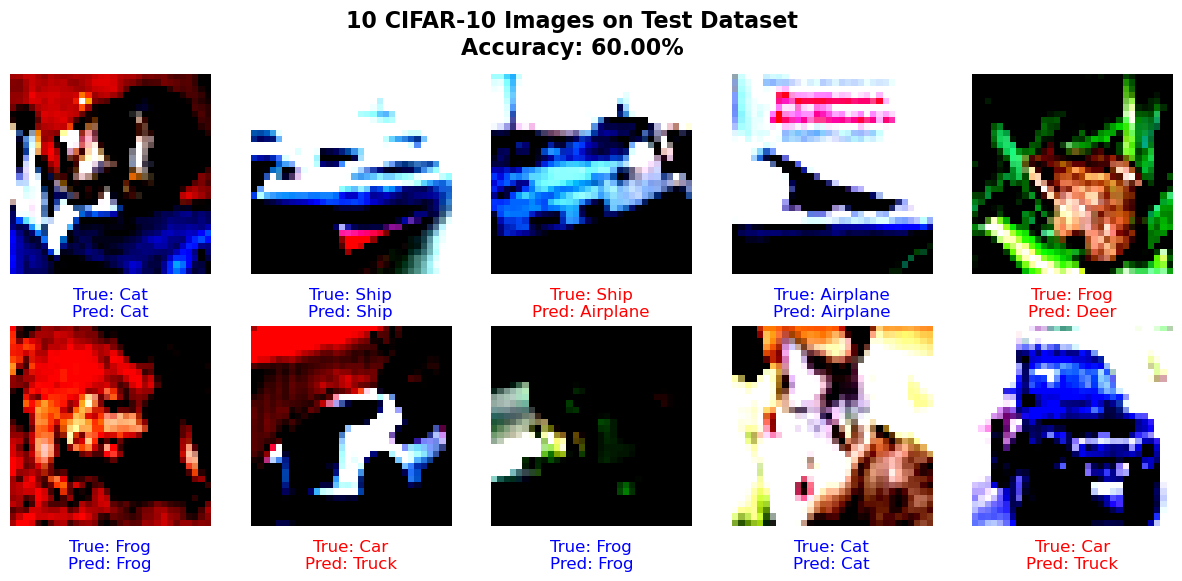

In [ ]:
def plot_random_images_with_predictions(model, data_loader, classes):
    # step1: get 10 sample images from the data loader
    images, labels = next(iter(data_loader))
    images, labels = images[:10], labels[:10]

    images = images.to(device)
    labels = labels.to(device)

    # step2: get model predictions and calculate accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    correct_count = (predicted == labels).sum().item()
    accuracy = correct_count / len(labels) * 100

    # step3: plot the images with the predicted labels
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(
        f"10 CIFAR-10 Images on Test Dataset\nAccuracy: {accuracy:.2f}%",
        fontsize=16,
        fontweight=600,
    )

    for i in range(10):
        ax = axes[i // 5, i % 5]
        img = np.transpose(images[i].numpy(), (1, 2, 0))

        ax.imshow(img)
        ax.axis("off")

        color = "blue" if predicted[i] == labels[i] else "red"
        ax.set_title(
            f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}",
            fontsize=12,
            color=color,
            y=-0.25,
        )

    plt.savefig("cifar10_predictions.svg", format="svg")
    plt.show()


plot_random_images_with_predictions(model, test_loader, classes)